In [1]:
import pandas as pd
import locale
import glob
import chardet

# Load data

In [2]:
def read_data_per_file(file: str) -> pd.DataFrame:
    """
    Reads data from a CSV file and returns it as a pandas DataFrame. Handles skipping rows

    Args:
        file (str): The path to the CSV file.

    Returns:
        pd.DataFrame: The DataFrame containing the data from the CSV file.
    """
    # Detect the encoding
    with open(file, 'rb') as f:
        result = chardet.detect(f.read())
        encoding = result['encoding']
    data =  pd.read_csv(file, encoding=encoding, skiprows=2)
        
    return data

In [3]:
def load_visitor_counts_data(
    data_folder: str,
) -> pd.DataFrame:
    """
    Loads visitor counts data from multiple CSV files in the specified folder and deletes some unnecessary column.

    Args:
        data_folder (str): The path to the folder containing the CSV files.

    Returns:
        pd.DataFrame: The DataFrame containing the visitor counts data.
    """
    # Read data from CSV files

    raw_visitor_counts = pd.concat([read_data_per_file(
        file
    ) for file in glob.glob(f"{data_folder}/*.csv")])
    
    # Drop last empty column
    visitor_counts = raw_visitor_counts.drop(columns=["Unnamed: 96"])

    return visitor_counts

visitor_counts = load_visitor_counts_data(data_folder="data")

# Preprocess data

In [4]:
# Check the data type of the 'Time' column
print(visitor_counts['Time'].dtype)

object


In [5]:
# Convert the 'Time' column to string if it's not already
visitor_counts['Time'] = visitor_counts['Time'].astype(str)

In [6]:
def parse_german_dates(
    df: pd.DataFrame,
    date_column_name: str
) -> pd.DataFrame:
    """
    Parses German dates in the specified date column of the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the date column.
        date_column_name (str): The name of the date column.

    Returns:
        pd.DataFrame: The DataFrame with parsed German dates.
    """
    
    # Set German locale
    locale.setlocale(locale.LC_TIME, "de_DE.UTF-8")
    
    # Mapping of German month names to their English equivalents
    month_map = {
        "Jan.": "Jan",
        "Feb.": "Feb",
        "März": "Mar",
        "Apr.": "Apr",
        "Mai": "May",
        "Juni": "Jun",
        "Juli": "Jul",
        "Aug.": "Aug",
        "Sep.": "Sep",
        "Okt.": "Oct",
        "Nov.": "Nov",
        "Dez.": "Dec"
    }

    # Replace German month names with English equivalents
    for german, english in month_map.items():
        df[date_column_name] = df[date_column_name].str.replace(german, english)

    # Parse the dates
    df[date_column_name] = pd.to_datetime(df[date_column_name], format="mixed")

         # Set the date column as the index
    df.set_index(date_column_name, inplace=True)

    return df

visitor_counts_parsed_dates = parse_german_dates(df=visitor_counts, date_column_name="Time")

Data Exploration


In [7]:
visitor_counts = visitor_counts_parsed_dates

In [8]:
# Checking if there are any missing values in the index
missing_index = visitor_counts.index.isnull().sum()
print(f"Number of missing values in the index: {missing_index}")

# Check for missing values (NaT) in the index
missing_in_index = visitor_counts.index.isna().sum()

print(f"Missing (NaT) values in the index: {missing_in_index}")

Number of missing values in the index: 8760
Missing (NaT) values in the index: 8760


Exploratory Data Analysis 

Resample the Data by Year

In [9]:
# Resample the data to yearly frequency and sum the counts
yearly_data = visitor_counts.resample('Y').sum()

C:\Users\HP Laptop\AppData\Local\Temp\ipykernel_9800\3733596179.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_data = visitor_counts.resample('Y').sum()


Calculate Yearly Totals

In [10]:
# Calculate the total visitors per year across all sensors
yearly_data['Total_Visitors'] = yearly_data.sum(axis=1)

# Display the yearly total visitors
print(yearly_data['Total_Visitors'])


Time
2018-12-31     585362.0
2019-12-31     711168.0
2020-12-31     926212.0
2021-12-31     985854.0
2022-12-31    1218797.0
2023-12-31    1618783.0
Name: Total_Visitors, dtype: object


Visualize Yearly Trends

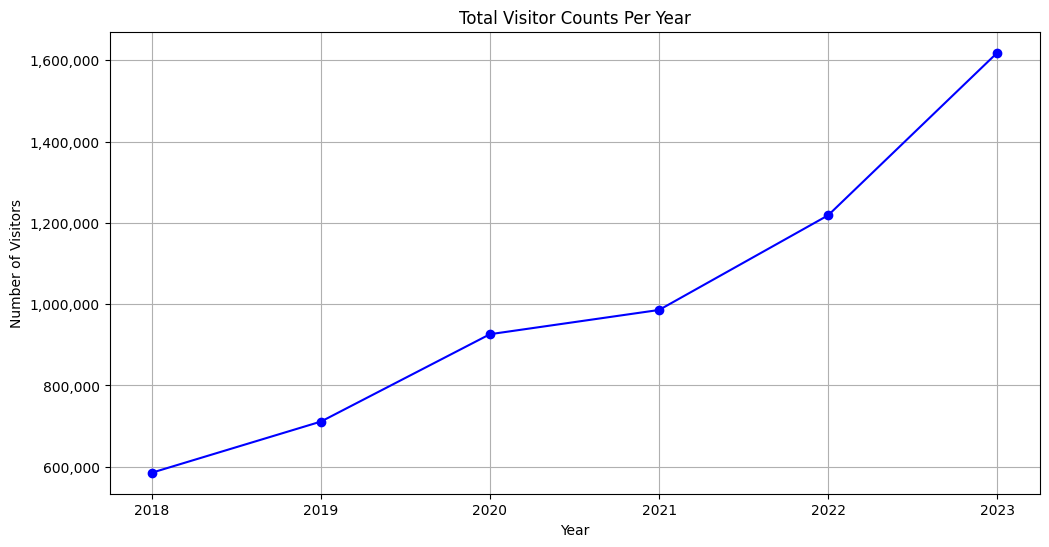

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Define a function to format the y-axis labels
def format_thousands(x, pos):
    'The two args are the value and tick position'
    return f'{int(x):,}'

# Plot the total visitors per year
plt.figure(figsize=(12, 6))
plt.plot(yearly_data.index.year, yearly_data['Total_Visitors'], marker='o', linestyle='-', color='b')

# Set title and labels
plt.title('Total Visitor Counts Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Visitors')

# Format the y-axis with thousands separator
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))

# Ensure all years are shown on x-axis
plt.xticks(yearly_data.index.year)

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.show()


Analyze Yearly Growth Rates

C:\Users\HP Laptop\AppData\Local\Temp\ipykernel_9800\1805097645.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  yearly_data['Yearly_Growth_Rate'] = yearly_data['Total_Visitors'].pct_change() * 100
posx and posy should be finite values


Time
2018-12-31          NaN
2019-12-31    21.492000
2020-12-31    30.238143
2021-12-31     6.439346
2022-12-31    23.628549
2023-12-31    32.818099
Name: Yearly_Growth_Rate, dtype: float64


posx and posy should be finite values


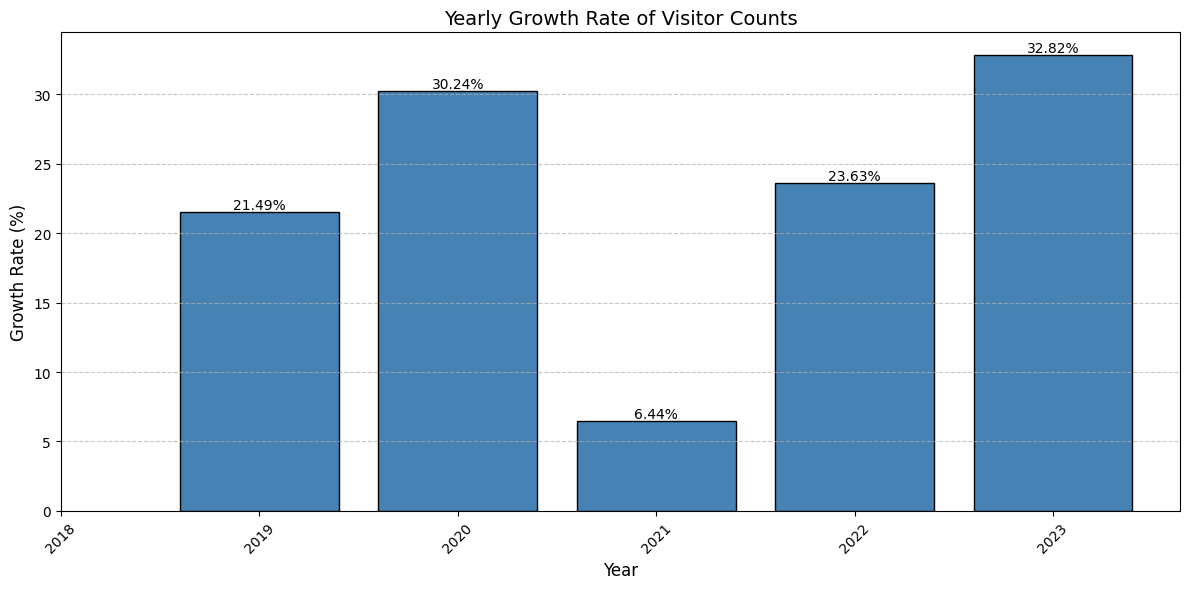

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the year-over-year percentage change
yearly_data['Yearly_Growth_Rate'] = yearly_data['Total_Visitors'].pct_change() * 100

# Display the growth rates (for verification)
print(yearly_data['Yearly_Growth_Rate'])

# Plot the growth rates
plt.figure(figsize=(12, 6))
bars = plt.bar(yearly_data.index.year, yearly_data['Yearly_Growth_Rate'], color='steelblue', edgecolor='black')

# Add annotations on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

# Customize the plot
plt.title('Yearly Growth Rate of Visitor Counts', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Growth Rate (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(yearly_data.index.year, rotation=45)  # Rotate x-ticks for better readability

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# Suppress FutureWarning
pd.options.mode.chained_assignment = None


Monthly Trends

C:\Users\HP Laptop\AppData\Local\Temp\ipykernel_9800\861781136.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = visitor_counts_parsed_dates.resample('M').sum()


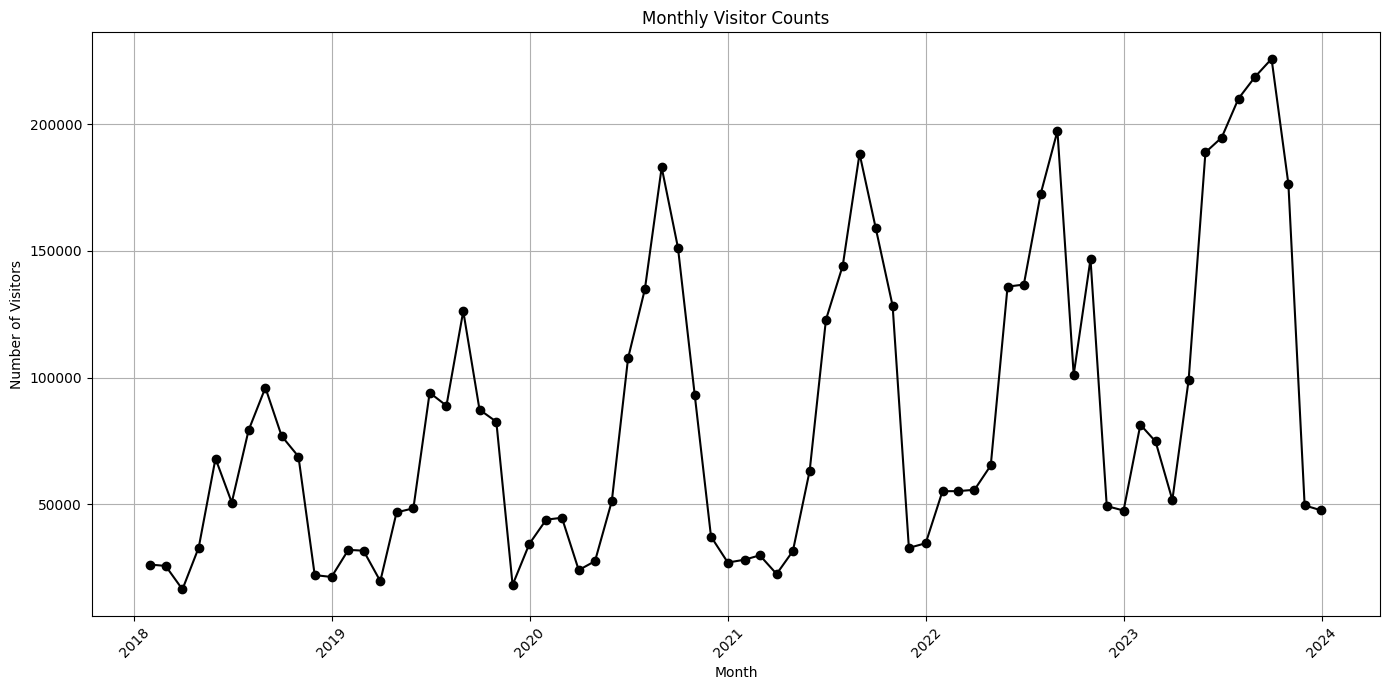

In [13]:
# Resample the data to a monthly frequency and sum the counts
monthly_data = visitor_counts_parsed_dates.resample('M').sum()

# Calculate monthly totals
monthly_data['Total_Visitors'] = monthly_data.sum(axis=1)

# Plot monthly trends
plt.figure(figsize=(14, 7))
plt.plot(monthly_data.index, monthly_data['Total_Visitors'], marker='o', linestyle='-', color='black')
plt.title('Monthly Visitor Counts')
plt.xlabel('Month')
plt.ylabel('Number of Visitors')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


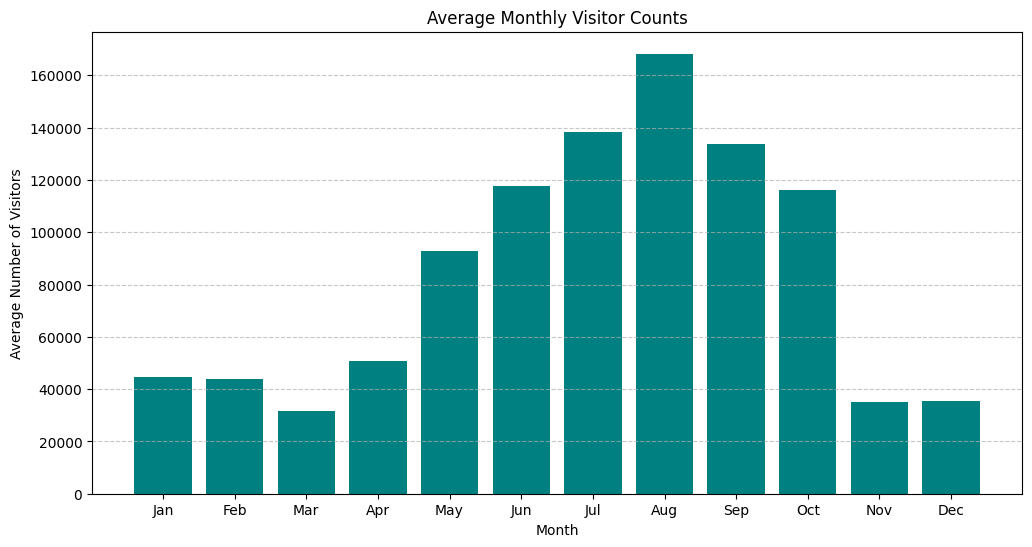

In [14]:
# Aggregate monthly data by year to find seasonal patterns
seasonal_data = monthly_data.groupby(monthly_data.index.month).mean()

# Plot average monthly visitor counts
plt.figure(figsize=(12, 6))
plt.bar(seasonal_data.index, seasonal_data['Total_Visitors'], color='teal')
plt.title('Average Monthly Visitor Counts')
plt.xlabel('Month')
plt.ylabel('Average Number of Visitors')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


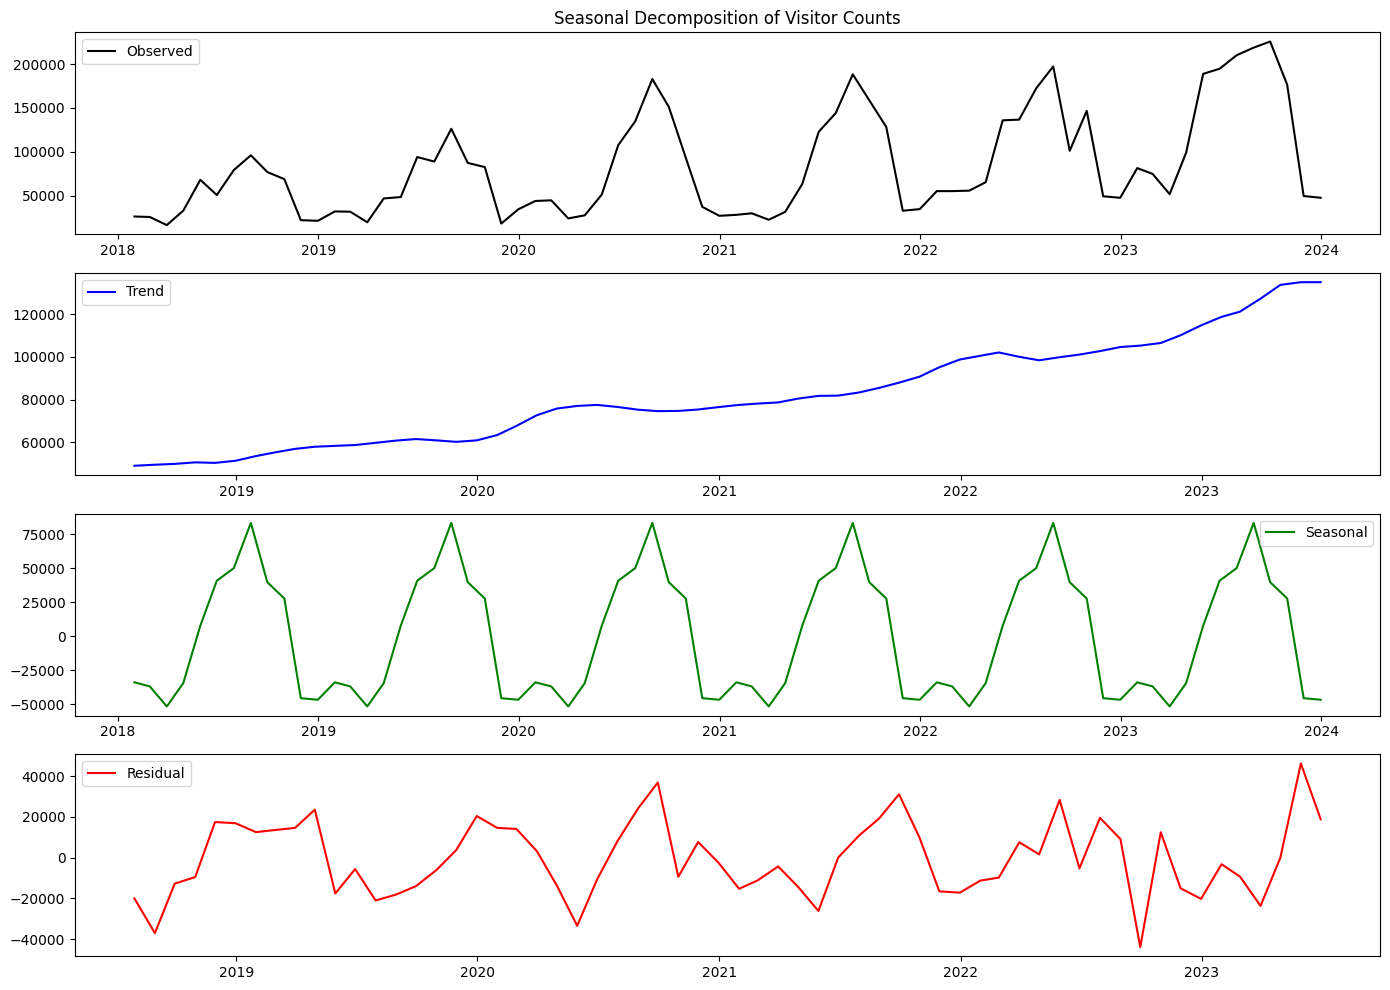

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(monthly_data['Total_Visitors'], model='additive')

# Plot the decomposition components
plt.figure(figsize=(14, 10))
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Observed', color='black')
plt.legend()
plt.title('Seasonal Decomposition of Visitor Counts')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.legend()

plt.tight_layout()
plt.show()
    

Summary of the above stat:

Observed: Your raw visitor data.

Trend: Long-term direction in visitor counts.

Seasonal: Periodic fluctuations or seasonal patterns.

Residual: Random noise or irregular deviations

Sensors Overview

c:\Users\HP Laptop\.pyenv-win-venv\envs\bf_dssgx\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


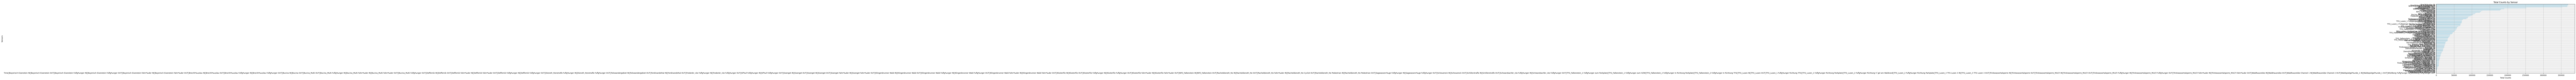

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert columns to numeric
visitor_counts = visitor_counts.apply(pd.to_numeric, errors='coerce')

# Drop non-numeric columns if necessary
numeric_columns = visitor_counts.select_dtypes(include=['number']).columns

# Sum the numeric columns
sensor_totals = visitor_counts[numeric_columns].sum()

# Plot the total counts for each sensor
plt.figure(figsize=(14, 7))
sensor_totals.sort_values().plot(kind='barh', color='skyblue')
plt.title('Total Counts by Sensor')
plt.xlabel('Total Counts')
plt.ylabel('Sensors')
plt.grid(True)
plt.show()


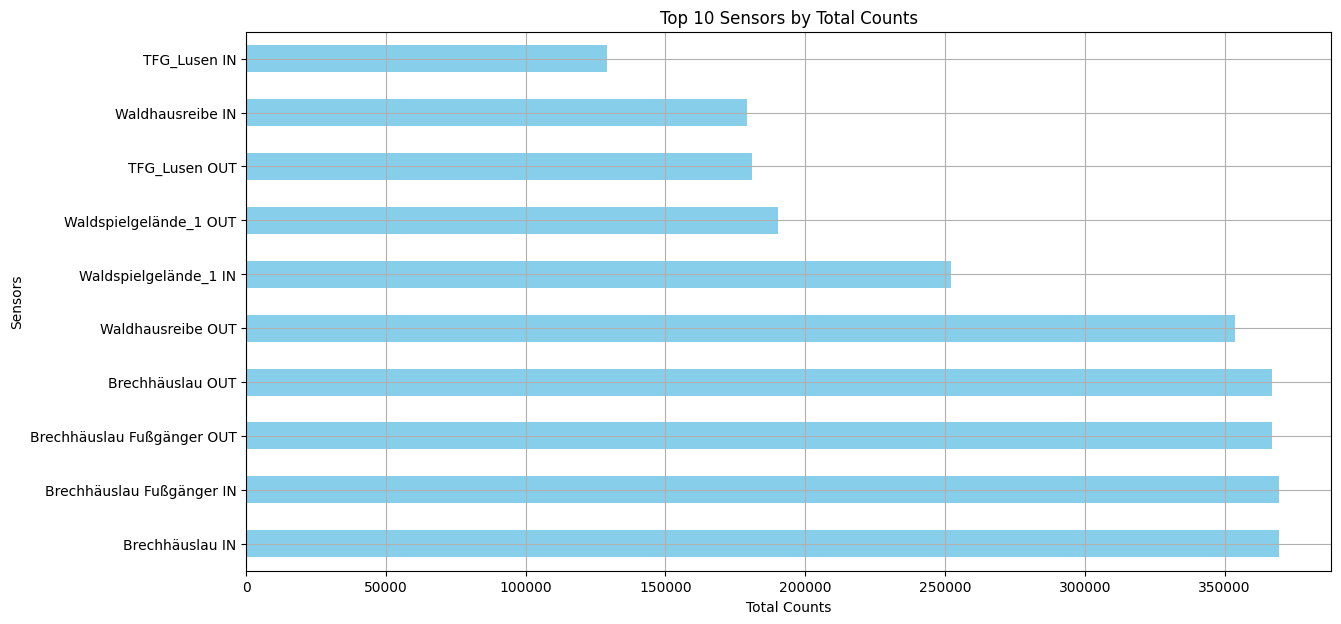

In [17]:
import matplotlib.pyplot as plt

# Select top 10 sensors by total counts
top_n = 10
top_sensors = sensor_totals.sort_values(ascending=False).head(top_n)

# Plot the top N sensors
plt.figure(figsize=(14, 7))
top_sensors.plot(kind='barh', color='skyblue')
plt.title(f'Top {top_n} Sensors by Total Counts')
plt.xlabel('Total Counts')
plt.ylabel('Sensors')
plt.grid(True)
plt.show()


In [18]:
visitor_counts.columns

Index(['Bayerisch Eisenstein IN', 'Bayerisch Eisenstein OUT',
       'Bayerisch Eisenstein Fußgänger IN',
       'Bayerisch Eisenstein Fußgänger OUT',
       'Bayerisch Eisenstein Fahrräder IN',
       'Bayerisch Eisenstein Fahrräder OUT', 'Brechhäuslau IN',
       'Brechhäuslau OUT', 'Brechhäuslau Fußgänger IN',
       'Brechhäuslau Fußgänger OUT', 'Bucina IN', 'Bucina OUT',
       'Bucina_Multi OUT', 'Bucina_Multi Fußgänger IN',
       'Bucina_Multi Fahrräder IN', 'Bucina_Multi Fahrräder OUT',
       'Bucina_Multi Fußgänger OUT', 'Deffernik IN', 'Deffernik OUT',
       'Deffernik Fahrräder IN', 'Deffernik Fahrräder OUT',
       'Deffernik Fußgänger IN', 'Deffernik Fußgänger OUT',
       'Diensthüttenstraße Fußgänger IN', 'Diensthüttenstraße Fußgänger OUT',
       'Felswandergebiet IN', 'Felswandergebiet OUT', 'Ferdinandsthal IN',
       'Ferdinandsthal OUT', 'Fredenbrücke Fußgänger IN',
       'Fredenbrücke Fußgänger OUT', 'Gfäll Fußgänger IN',
       'Gfäll Fußgänger OUT', 'Gsenget 

In [19]:
# Identify columns related to pedestrians and bicycles
pedestrian_columns = [col for col in visitor_counts_parsed_dates.columns if 'Fußgänger IN' in col]
bicycle_columns = [col for col in visitor_counts_parsed_dates.columns if 'Fahrräder IN' in col]

# Separate the data for pedestrians and bicycles
pedestrian_data = visitor_counts_parsed_dates[pedestrian_columns]
bicycle_data = visitor_counts_parsed_dates[bicycle_columns]

print(f"Total pedestrian sensors: {len(pedestrian_columns)}")
print(f"Total bicycle sensors: {len(bicycle_columns)}")


Total pedestrian sensors: 13
Total bicycle sensors: 8


In [20]:
# Sum up pedestrian and bicycle counts across all sensors
pedestrian_data['Total_Pedestrians'] = pedestrian_data.sum(axis=1)
bicycle_data['Total_Bicycles'] = bicycle_data.sum(axis=1)

# Calculate daily averages
daily_avg_pedestrians = pedestrian_data['Total_Pedestrians'].resample('D').mean()
daily_avg_bicycles = bicycle_data['Total_Bicycles'].resample('D').mean()

# Calculate monthly averages
monthly_avg_pedestrians = pedestrian_data['Total_Pedestrians'].resample('ME').mean()
monthly_avg_bicycles = bicycle_data['Total_Bicycles'].resample('ME').mean()

# Display the results
print(f"Average daily pedestrians: {daily_avg_pedestrians.mean()}")
print(f"Average daily bicycles: {daily_avg_bicycles.mean()}")


Average daily pedestrians: 15.659535219838736
Average daily bicycles: 2.061216339570972


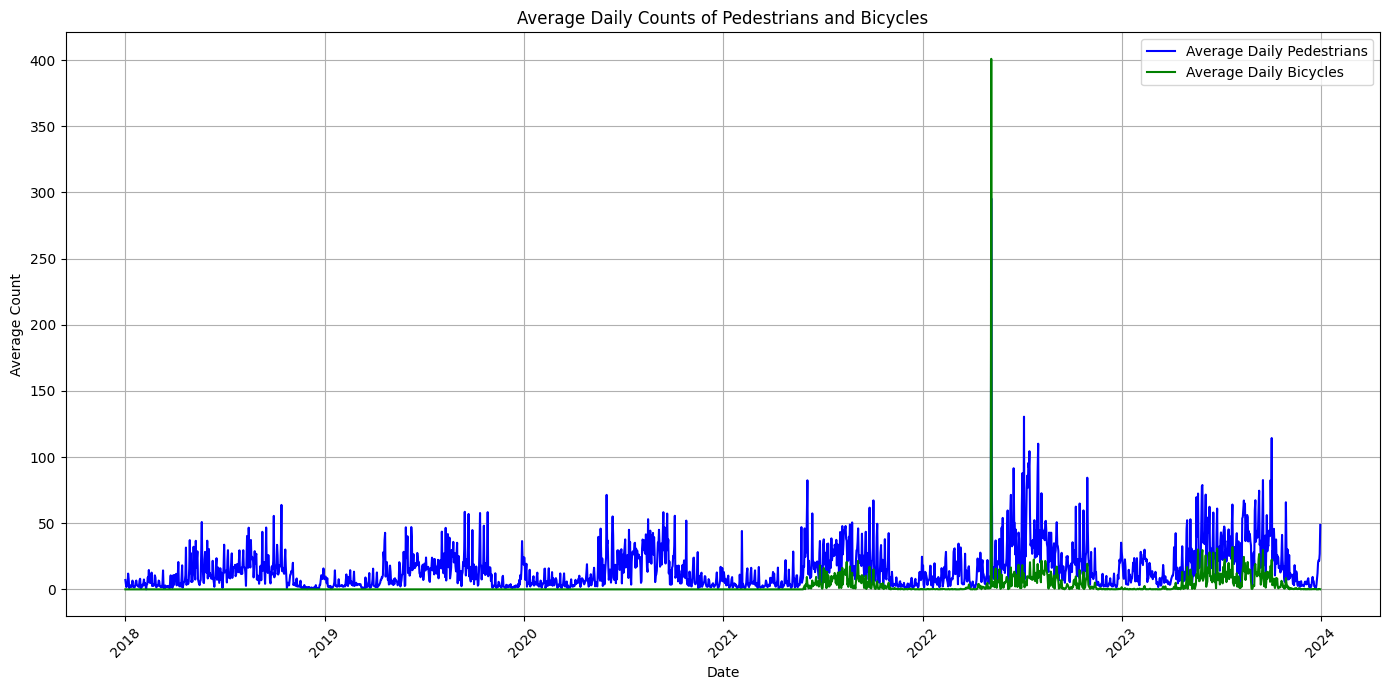

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(daily_avg_pedestrians.index, daily_avg_pedestrians, label='Average Daily Pedestrians', color='blue')
plt.plot(daily_avg_bicycles.index, daily_avg_bicycles, label='Average Daily Bicycles', color='green')
plt.title('Average Daily Counts of Pedestrians and Bicycles')
plt.xlabel('Date')
plt.ylabel('Average Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\HP Laptop\AppData\Local\Temp\ipykernel_9800\4105169468.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_pedestrians = pedestrian_data['Total_Pedestrians'].resample('M').mean()
C:\Users\HP Laptop\AppData\Local\Temp\ipykernel_9800\4105169468.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_bicycles = bicycle_data['Total_Bicycles'].resample('M').mean()


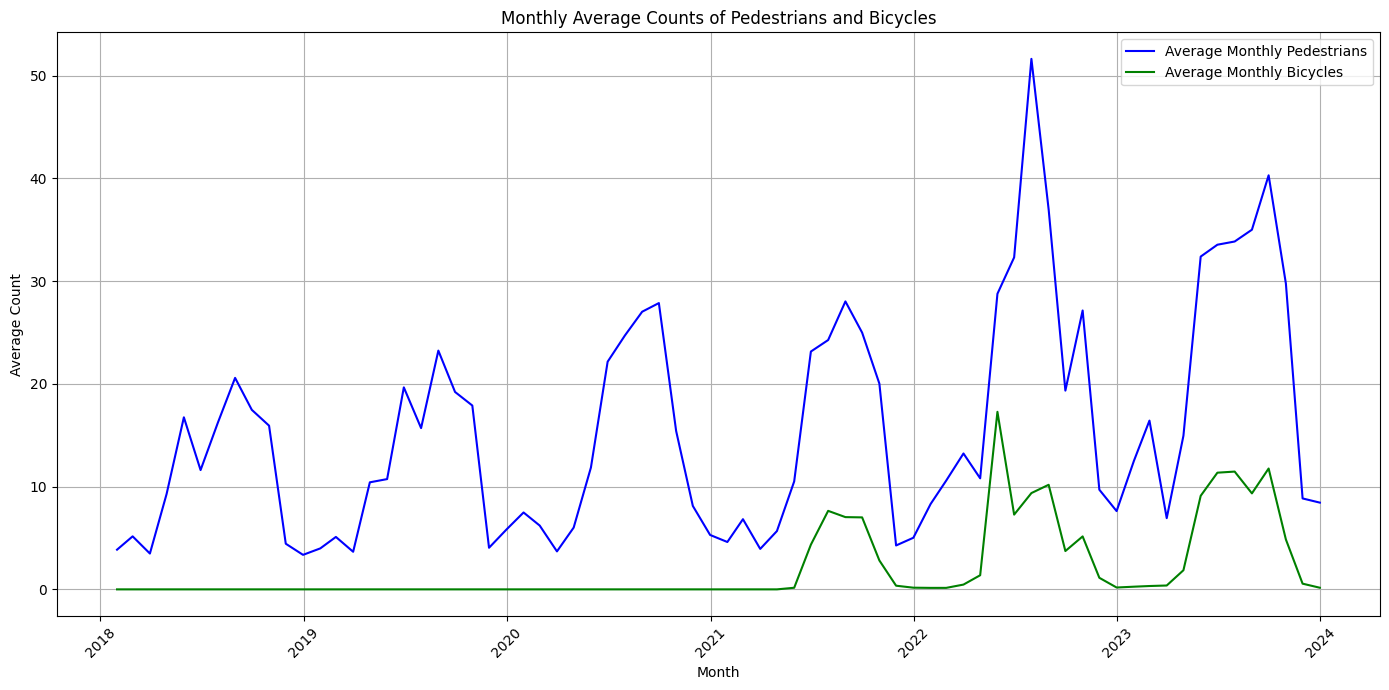

In [22]:
# Plot monthly averages
monthly_avg_pedestrians = pedestrian_data['Total_Pedestrians'].resample('M').mean()
monthly_avg_bicycles = bicycle_data['Total_Bicycles'].resample('M').mean()

plt.figure(figsize=(14, 7))
plt.plot(monthly_avg_pedestrians.index, monthly_avg_pedestrians, label='Average Monthly Pedestrians', color='blue')
plt.plot(monthly_avg_bicycles.index, monthly_avg_bicycles, label='Average Monthly Bicycles', color='green')
plt.title('Monthly Average Counts of Pedestrians and Bicycles')
plt.xlabel('Month')
plt.ylabel('Average Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


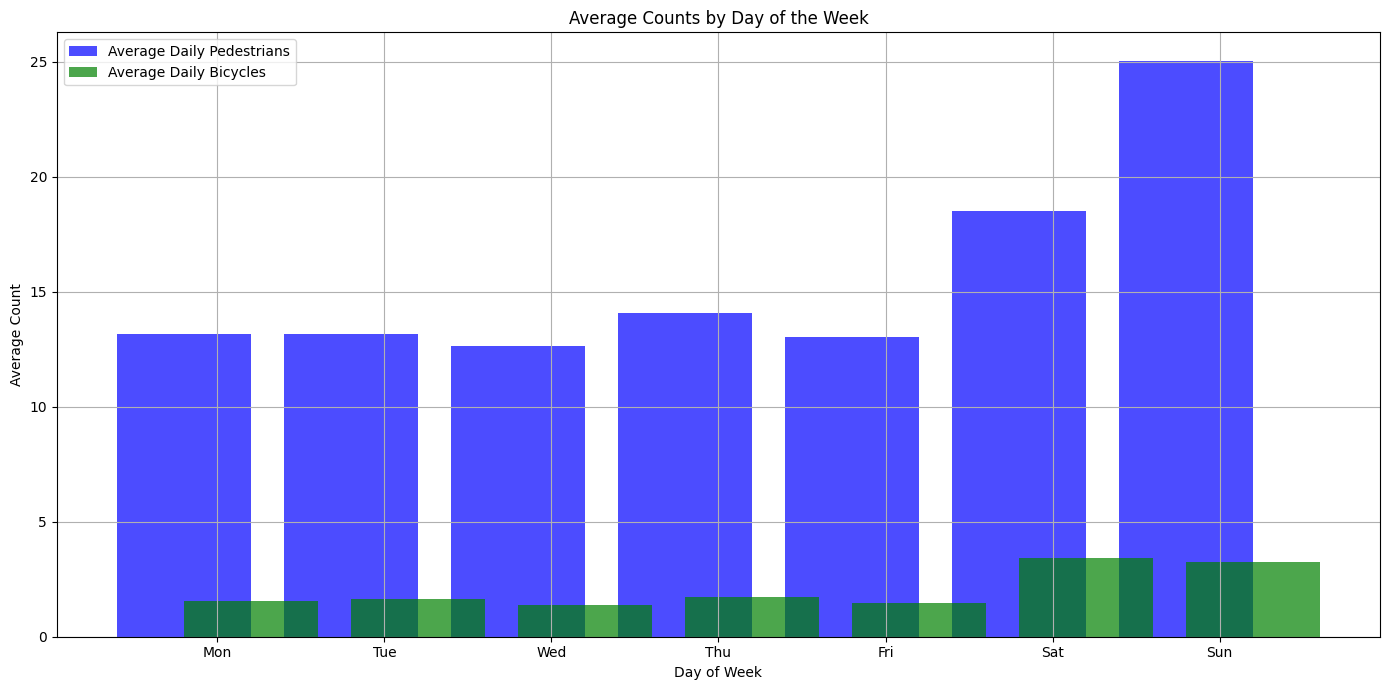

In [23]:
# Extract day of week and calculate average counts
pedestrian_data['Day_of_Week'] = pedestrian_data.index.dayofweek
bicycle_data['Day_of_Week'] = bicycle_data.index.dayofweek

daily_avg_weekday_pedestrians = pedestrian_data.groupby('Day_of_Week')['Total_Pedestrians'].mean()
daily_avg_weekday_bicycles = bicycle_data.groupby('Day_of_Week')['Total_Bicycles'].mean()

# Plot day of week averages
plt.figure(figsize=(14, 7))
plt.bar(daily_avg_weekday_pedestrians.index, daily_avg_weekday_pedestrians, label='Average Daily Pedestrians', color='blue', alpha=0.7)
plt.bar(daily_avg_weekday_bicycles.index + 0.4, daily_avg_weekday_bicycles, label='Average Daily Bicycles', color='green', alpha=0.7)
plt.title('Average Counts by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Count')
plt.xticks(ticks=daily_avg_weekday_pedestrians.index + 0.2, labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Find the Busiest Sensor

In [24]:
# Calculate the total visitor counts for each sensor over the entire period
total_visitors_per_sensor = visitor_counts_parsed_dates.sum()

# Identify the busiest sensor
busiest_sensor = total_visitors_per_sensor.idxmax()
busiest_sensor_visitors = total_visitors_per_sensor.max()

print(f"The busiest sensor is: {busiest_sensor} with {busiest_sensor_visitors} total visitors.")
    

TypeError: unsupported operand type(s) for +: 'int' and 'str'

Analyze Traffic Variation by Month for the Busiest Sensor

In [26]:
# Extract data for the busiest sensor
busiest_sensor_data = visitor_counts_parsed_dates[busiest_sensor]

# Resample to monthly frequency
monthly_busiest_sensor = busiest_sensor_data.resample('M').sum()

# Calculate average monthly counts
monthly_avg = monthly_busiest_sensor.groupby(monthly_busiest_sensor.index.month).mean()

# Plot the monthly averages
plt.figure(figsize=(12, 6))
plt.bar(monthly_avg.index, monthly_avg, color='steelblue')
plt.title(f'Average Monthly Visitor Counts for {busiest_sensor}')
plt.xlabel('Month')
plt.ylabel('Average Number of Visitors')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


NameError: name 'busiest_sensor' is not defined

Forecasting and Predictive Analysis

SARIMA Model for Visitor Count Forecasting


The Seasonal ARIMA (SARIMA) model is an extension of the ARIMA model used for time series forecasting, particularly effective for data with seasonal patterns. In our case, where visitor counts show trends and seasonal variations (e.g., more visitors in summer), SARIMA helps us capture both the overall trend and the seasonality.

Implementation:

Data Preparation: Resampled the data to monthly totals to focus on seasonal trends.

Model Definition: Specified SARIMA parameters that reflect both the short-term and seasonal dependencies in the data.

Model Fitting: The model is trained on historical data to understand underlying patterns.

Forecasting: The trained model is used to predict future visitor counts, giving insights into expected trends.

In [27]:
monthly_data = visitor_counts_parsed_dates.resample('M').sum()

C:\Users\HP Laptop\AppData\Local\Temp\ipykernel_9800\1732069065.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = visitor_counts_parsed_dates.resample('M').sum()


C:\Users\HP Laptop\AppData\Local\Temp\ipykernel_9800\4080304376.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = monthly_data.asfreq('M')
C:\Users\HP Laptop\AppData\Local\Temp\ipykernel_9800\4080304376.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=monthly_data.index[-1], periods=13, freq='M')[1:]


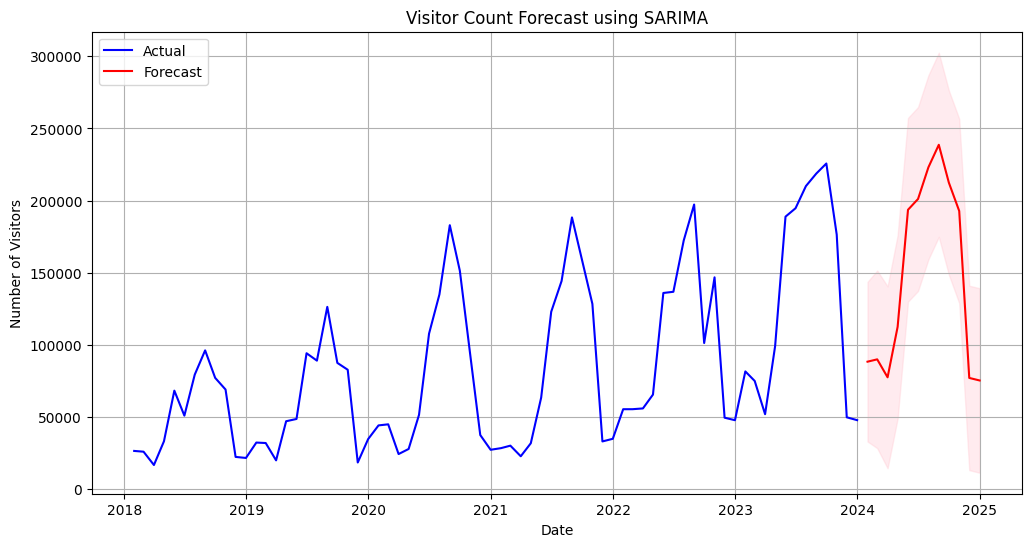

In [29]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Check if 'Total_Visitors' needs to be created by summing across all columns
if 'Total_Visitors' not in monthly_data.columns:
    monthly_data['Total_Visitors'] = monthly_data.sum(axis=1)

# Convert 'Total_Visitors' to numeric, forcing any non-numeric values to NaN
monthly_data['Total_Visitors'] = pd.to_numeric(monthly_data['Total_Visitors'], errors='coerce')

# Drop any rows with NaN values that might have been created during conversion
monthly_data.dropna(subset=['Total_Visitors'], inplace=True)

# Ensure the index is a DateTimeIndex with a frequency set
monthly_data.index = pd.to_datetime(monthly_data.index)
monthly_data = monthly_data.asfreq('ME')

# Define the SARIMA model
model = SARIMAX(monthly_data['Total_Visitors'], 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 12))

# Fit the model
model_fit = model.fit()

# Forecast the next 12 months
forecast = model_fit.get_forecast(steps=12)
forecast_index = pd.date_range(start=monthly_data.index[-1], periods=13, freq='M')[1:]
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# Plot the actual data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data['Total_Visitors'], label='Actual', color='blue')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='red')
plt.fill_between(forecast_series.index,
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.title('Visitor Count Forecast using SARIMA')
plt.xlabel('Date')
plt.ylabel('Number of Visitors')
plt.legend()
plt.grid(True)
plt.show()
